<a href="https://colab.research.google.com/github/pushkershukla/adv_fairness/blob/main/Adverserial_examples_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

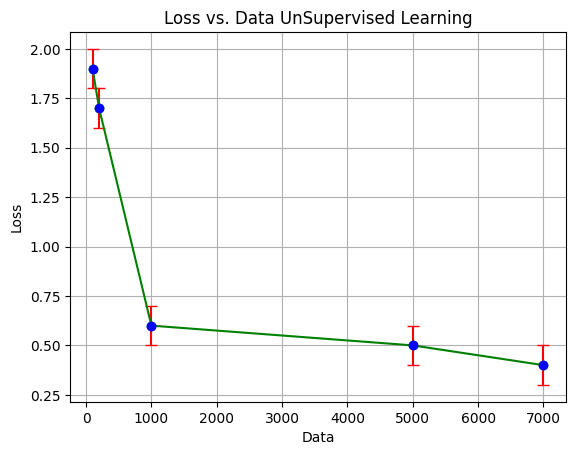

In [ ]:
import matplotlib.pyplot as plt

data = [100, 200, 1000, 5000, 7000]
acc = [1.9, 1.7, 0.6,0.5, 0.4]
var = [0.1, 0.1, 0.1, 0.1, 0.1]

plt.errorbar(data, acc, yerr=var, fmt='o', color='b', ecolor='r', capsize=4)
plt.plot(data, acc, color='g', linestyle='-', marker='o')
plt.xlabel('Data')
plt.ylabel('Loss')
plt.title('Loss vs. Data UnSupervised Learning')
plt.grid(True)
plt.show()

In [ ]:

! pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.25.1 which is incompatible.
tweepy 4.13.0 requires requests<3,>=2.27.0, but you have requests 2.25.1 which is inco

In [ ]:
# all imports

import os
import json
import numpy as np
import PIL.Image as Image
import torchattacks
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, models
import torch.utils.data as data
import zipfile
import pandas as pd
import torchvision
import time
# reproducibility
seed = 42
# SYSTEM
np.random.seed(seed)
#CUDA
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)
# CUDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# version
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 2.0.0+cu118
GPU-enabled installation? False


In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_dir='/content/gdrive/MyDrive/downloads/celeba/celeba.zip'

with zipfile.ZipFile(dataset_dir,"r") as zip_ref:
  zip_ref.extractall("faces/")

with zipfile.ZipFile("faces/celeba/img_align_celeba.zip","r") as zip_ref:
  zip_ref.extractall("faces/celeba")

In [ ]:
image_path="faces"

In [ ]:
data_root='faces/celeba'
dataset_folder = f'{data_root}/img_align_celeba'
print(dataset_folder)

faces/celeba/img_align_celeba


In [ ]:
from torch.utils.data import DataLoader
get_smile = lambda attr: attr[31]
smile_attr_idx=31
gender_attr_idx=20
transform_train = transforms.Compose([
     transforms.RandomCrop([178, 178]),
     transforms.RandomHorizontalFlip(),
     transforms.Resize([224, 224]),
     transforms.ToTensor(),
 ])
transform = transforms.Compose([
     transforms.CenterCrop([178, 178]),
     transforms.Resize([224, 224]),
     transforms.ToTensor(),
 ])

celeba_train_dataset = torchvision.datasets.CelebA(
     image_path, split='train',
     target_type='attr', download=False,
     transform=transform_train
 )


celeba_valid_dataset = torchvision.datasets.CelebA(
     image_path, split='valid',
     target_type='attr', download=False,
     transform=transform
 )
celeba_test_dataset = torchvision.datasets.CelebA(
     image_path, split='test',
     target_type='attr', download=False,
     transform=transform
 )
#Training our model on 16000 dataponints initially  and 1000 validation poitns
#Change this later
from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset,
                               torch.arange(50000))
celeba_valid_dataset = Subset(celeba_valid_dataset,
                               torch.arange(5000))
#print('Train set:', len(celeba_train_dataset))

#print('Validation set:', len(celeba_valid_dataset))

In [ ]:
batch_size = 256
torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset,
                       batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset,
                       batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset,
                     batch_size, shuffle=False)
smile_attr_idx=31
gender_attr_idx=20

In [ ]:
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2
feature_extract=True
num_epochs=5

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained='vggface2')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc=nn.Sequential(
                model_ft.fc,
                nn.Softmax(),
                )
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained='vggface2')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained='vggface2')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained='vggface2')
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained='vggface2')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained='vggface2')
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
#model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)

In [ ]:
model_smile, input_size = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.46MB/s]


In [ ]:
model_gender, input_size = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)

In [ ]:
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismtach found at', key_item_1[0])
            else:
                raise Exception
    if models_differ == 0:
        print('Models match perfectly! :)')
compare_models(model_gender,model_smile)
compare_models(model_gender,model_smile)

Mismtach found at fc.0.weight
Mismtach found at fc.0.bias
Mismtach found at fc.0.weight
Mismtach found at fc.0.bias


In [ ]:
def load_model(model,model_name,model_path,device):
  final_path=os.path.join(model_path,model_name)

  model = model.to(device)
  model_weights = torch.load(final_path,map_location=device)
  model.load_state_dict(model_weights)
  model.eval()
  return model

In [ ]:
smile_model_name="balanced_smile_model3.pt"
smile_model_path="/content/gdrive/MyDrive/FairFaceRecExptResults/"

In [ ]:
model_smile=load_model(model_smile,smile_model_name,smile_model_path,device)

In [ ]:
gender_model_name="balanced_gender_model3.pt"
gender_model_path="/content/gdrive/MyDrive/FairFaceRecExptResults/"

In [ ]:
model_gender=load_model(model_gender,gender_model_name,gender_model_path,device)

In [ ]:
compare_models(model_gender,model_smile)

Mismtach found at bn1.running_mean
Mismtach found at bn1.running_var
Mismtach found at bn1.num_batches_tracked
Mismtach found at layer1.0.bn1.running_mean
Mismtach found at layer1.0.bn1.running_var
Mismtach found at layer1.0.bn1.num_batches_tracked
Mismtach found at layer1.0.bn2.running_mean
Mismtach found at layer1.0.bn2.running_var
Mismtach found at layer1.0.bn2.num_batches_tracked
Mismtach found at layer1.1.bn1.running_mean
Mismtach found at layer1.1.bn1.running_var
Mismtach found at layer1.1.bn1.num_batches_tracked
Mismtach found at layer1.1.bn2.running_mean
Mismtach found at layer1.1.bn2.running_var
Mismtach found at layer1.1.bn2.num_batches_tracked
Mismtach found at layer2.0.bn1.running_mean
Mismtach found at layer2.0.bn1.running_var
Mismtach found at layer2.0.bn1.num_batches_tracked
Mismtach found at layer2.0.bn2.running_mean
Mismtach found at layer2.0.bn2.running_var
Mismtach found at layer2.0.bn2.num_batches_tracked
Mismtach found at layer2.0.downsample.1.running_mean
Mismtach

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def get_pred(model, images, device,logits='False'):
    #print("Device",device)
    #print("Model", type(model))
    #print("Images",type(images))
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)

    return pres.cpu(),logits.cpu()



def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [ ]:
import torchattacks
from torchattacks import PGD

In [ ]:
atk = torchattacks.FGSM(model_gender, eps=1/255)
print(atk)

FGSM(model_name=ResNet, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=0.00392156862745098)


In [ ]:

#print(type(test_dl))
#for images, labels in test_dl(1):
  #print("Gender",(labels[:,gender_attr_idx]))
  #print (images.shape)
  #pred,logits=get_pred(model_gender,images,device)
  #print(pred)
it=iter(test_dl)
images,labels=next(it)
gender_labels=labels[:,gender_attr_idx]
smile_labels=labels[:,smile_attr_idx]
gender_pred,gender_logits,=get_pred(model_gender,images,device)
adv_images = atk(images, gender_pred)

##print(gender_labels)
#print(smile_labels)
#print(labels.shape)
#print(images.shape)
#print(print("Gender",(labels[:,gender_attr_idx])))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
print(images.shape)
print(type(images))
print(type(gender_pred))
print(gender_logits.size())
print(gender_pred)

torch.Size([256, 3, 224, 224])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([256, 2])
tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1])


In [ ]:
'''
idx = 6
ad_gen_pre,ad_gen_val = get_pred(model_gender, adv_images, device)
gen_pre,gen_val=get_pred(model_gender,images,device)
print("Gender Adverserial",ad_gen_pre,ad_gen_val)
print("Gender_normal",gen_pre,gen_val)

ad_smi_pre,ad_smi_val=get_pred(model_smile,adv_images[idx:idx+4],device)
smi_pre,smi_val=get_pred(model_smile,images[idx:idx+4],device)
print("Smile adverserial",ad_smi_pre, ad_smi_val)
print("Smile normal",smi_pre, smi_val)
'''

'\nidx = 6\nad_gen_pre,ad_gen_val = get_pred(model_gender, adv_images, device)\ngen_pre,gen_val=get_pred(model_gender,images,device)\nprint("Gender Adverserial",ad_gen_pre,ad_gen_val)\nprint("Gender_normal",gen_pre,gen_val)\n\nad_smi_pre,ad_smi_val=get_pred(model_smile,adv_images[idx:idx+4],device)\nsmi_pre,smi_val=get_pred(model_smile,images[idx:idx+4],device)\nprint("Smile adverserial",ad_smi_pre, ad_smi_val)\nprint("Smile normal",smi_pre, smi_val)\n'

In [ ]:
'''
adv_attack_eps={}
gender_pred,gender_logits=get_pred(model_gender,images,device)
smile_pred,smile_logits=get_pred(model_smile,images,device)
#adv_attack=torchattacks.FGSM(model_gender, eps=i*4/255)

for i in range (0,8):
    atk = torchattacks.BIM(model_gender, eps=i*1/1000, alpha=2/255, steps=5)
    adv_images = atk(images, gender_pred)
    adv_gender_pred,adv_gen_logits=get_pred(model_gender,adv_images,device)
    adv_smile_pred,adv_smile_logits=get_pred(model_smile,adv_images,device)
    adv_attack_eps.update({i:{"adv_gend_pred":adv_gender_pred,
                             "adv_gen_logits":adv_gen_logits,
                             "adv_smile_pred":adv_smile_pred,
                             "adv_smile_logits":adv_smile_logits}})



'''

'\nadv_attack_eps={}\ngender_pred,gender_logits=get_pred(model_gender,images,device)\nsmile_pred,smile_logits=get_pred(model_smile,images,device)\n#adv_attack=torchattacks.FGSM(model_gender, eps=i*4/255)\n\nfor i in range (0,8):\n    atk = torchattacks.BIM(model_gender, eps=i*1/1000, alpha=2/255, steps=5)\n    adv_images = atk(images, gender_pred)\n    adv_gender_pred,adv_gen_logits=get_pred(model_gender,adv_images,device)\n    adv_smile_pred,adv_smile_logits=get_pred(model_smile,adv_images,device)\n    adv_attack_eps.update({i:{"adv_gend_pred":adv_gender_pred,\n                             "adv_gen_logits":adv_gen_logits,\n                             "adv_smile_pred":adv_smile_pred,\n                             "adv_smile_logits":adv_smile_logits}})\n  \n\n\n'

In [ ]:
#def calcuate_noise(images,adv_images):

eps_value=[0.000001,0.00001,0.0001,0.001,0.005,0.01,0.02,0.025,0.05,0.075]#,0.25]

In [ ]:

def get_plots(img,lbl,eps_value,atk_name='FGSM',device=device):
  print (img.shape)
  preds={"img":img,
      "gender_labels":lbl[gender_attr_idx].tolist(),
    "smile_labels":lbl[smile_attr_idx].tolist(),
    "gender_pred":get_pred(model_gender,img,device)[0][0].tolist(),
    "gender_logits":get_pred(model_gender,img,device)[1][0].tolist(),
    "smile_pred":get_pred(model_smile,img,device)[0][0].tolist(),
    "smile_logits":get_pred(model_smile,img,device)[1][0].tolist(),
    "eps":{}
  }

  for eps in eps_value:
    preds["eps"].update({eps:{
                    "adv_gen_logits":None,
                    "adv_smile_logits":None,
                    "adv_gender_pred":[],
                    "adv_smile_pred":[],
                    "adv_imgs":None}})
    #

    if (atk_name=='Square'):
        print(atk_name)

        #atk = torchattacks.Square(model_gender ,norm='Linf', eps=eps, n_queries=2000, n_restarts=1, p_init=.8, seed=0)
        #atk = torchattacks.Pixle(model_gender, x_dimensions=(0.1, 0.2), restarts=10)#, iteration=10)
        num_pixel=224*224
        print(max(int(eps*num_pixel),1))
        atk = torchattacks.OnePixel(model_gender, pixels=max(int(eps*num_pixel/10),1), steps=5, popsize=10, inf_batch=128)
    if (atk_name=='FGSM'):
        print(atk_name)
        atk = torchattacks.FGSM(model_gender, eps=eps)

      #adv_images = attack(images, labels)
    elif(atk_name=='GN'):
        atk = torchattacks.GN(model_gender,std=eps)
    preds["eps"][eps]["adv_imgs"] = atk(img, get_pred(model_gender,img,device)[0])
    preds["eps"][eps]["adv_gender_pred"],preds["eps"][eps]["adv_gen_logits"]=get_pred(model_gender,preds["eps"][eps]["adv_imgs"],device)
    preds["eps"][eps]["adv_smile_pred"],preds["eps"][eps]["adv_smile_logits"]=get_pred(model_smile,preds["eps"][eps]["adv_imgs"],device)

  return preds
#k=30,31,50,55,27,78,122,187,59
img_id=27
it=iter(test_dl)
images,labels=next(it)
print(labels[img_id,:])


def calc_values(images,img_id,eps_value,atk_name='FGSM'):
    preds=get_plots(images[img_id].unsqueeze(dim=0),labels[img_id,:],eps_value,atk_name)
    gender_values=[preds["gender_logits"][1]]
    smile_values=[preds["smile_logits"][1]]
    print(gender_values,smile_values)
    print(preds["gender_logits"],preds["smile_logits"])
    eps_ext=[0]
    list_images=[images[img_id].unsqueeze(dim=0)]
    for key in preds["eps"].keys():
        #print(preds["eps"][key])
        gender_values.append(preds["eps"][key]["adv_gen_logits"].tolist()[0][1])
        smile_values.append(preds["eps"][key]["adv_smile_logits"].tolist()[0][1])
        list_images.append(preds["eps"][key]["adv_imgs"])
        eps_ext.append(key)
    return gender_values,smile_values,list_images,eps_ext,preds


tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
import seaborn as sns
gender_values,smile_values,list_images,eps_ext,preds=calc_values(images,img_id,eps_value,atk_name='FGSM')


torch.Size([1, 3, 224, 224])
FGSM


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


FGSM
FGSM
FGSM
FGSM
FGSM
FGSM
FGSM
FGSM
FGSM
[0.9999854564666748] [0.9994626641273499]
[1.4496314179268666e-05, 0.9999854564666748] [0.0005374018801376224, 0.9994626641273499]


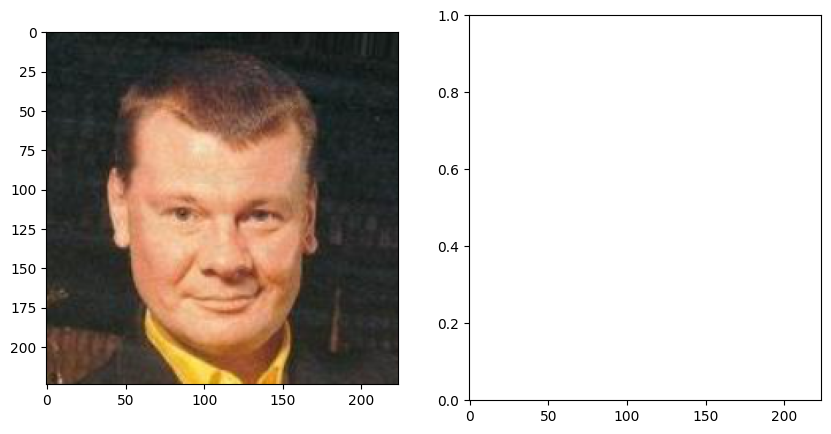

In [ ]:
#@title Default title text
def show_images(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
    axes[0].imshow(np.transpose(npimg,(1,2,0)))

    #axes[0].title(title)
    #axes[0].show()
#print(images.size())
#print((preds["img"]).size())
# Plot an image and the plots
#fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
#axes[0].imshow(preds["eps"][0.075]["adv_imgs"].squeeze(),"Original Image")
show_images(preds["img"], "Original Image")

In [ ]:

class adverserial_analysis:
    def __init__(self,atk_name,classifier,concept_model,
                 classifier_pred,concept_pred,
                 classifier_pred_kwargs,concept_pred_kwargs,
                 atk_kwargs):

      '''
      Variables :-
      atk_name :- Name of the attack
      classifier :- the oroginal classifier model (Eg:- Smile detector model or Melanoma Classifier)
      concept_model:- The concept_detection model (Eg:- Skin detector or gender classifier)
      classifier_pred :- The function returning the output of the classifier. The output
                          should be a tuple containing the class index and output probabilities of the classifier
      concept_pred :- The function returning the output of the concept. The output
                          should be a tuple containing the class index and output probabilities of the classifier

      classifier_pred_kwargs :- Dictionary containting the parameters associated with the classifier function
      concept_pred_kwargs:-  Dictionary containting the parameters associated with the concept
      atk_kwargs :- Dictionary containing the parameters associated with the adverserial attack
      '''
      self.atk_name=atk_name
      self.classifier=classifier
      self.concept_model=concept_model
      self.classifier_pred=classifier_pred
      self.concept_pred=concept_pred
      self.classifier_pred_kwargs=classifier_pred_kwargs
      self.concept_pred_kwargs=concept_pred_kwargs
      self.atk_kwargs=atk_kwargs
      self.atk=None


    def generate_adverserial_attack(self,atk_name,kwargs=None):
      '''
      Function that returns the adequate adveserial attack
      Input :-
      atk_name - Name of the attack
      kwargs:- Paramaeters associated with the attack
      Output :- the attack initialized
      '''
      print("Attack _name",atk_name)
      print("Kwargs",kwargs)
      atk=None
      if kwargs is None:
        kwargs=self.atk_kwargs
      if atk_name is None:
        atk_name = self.atk_name
      if (atk_name=='Square'):
        atk= torchattacks.Square(self.concept_model,**kwargs)
      if (atk_name=='FGSM'):
        atk= torchattacks.FGSM(self.concept_model,**kwargs)
      if (atk_name=='BIM'):
        pass
      if (atk_name=='PGD'):
        pass
      if (atk_name=="OnePixel"):
        pass
      if (atk_name=="random") :
        print("there")
        atk= torchattacks.attacks.gn.GN(self.concept_model,**kwargs)
      print( "Torch attack USed",atk)
      return atk
    def generate_adverserial_images(self,imgs,classifier_fn=None,
                                    pred_fn=None,pred_kwargs=None,
                                    atk_name=None,atk_kwargs=None):
        '''
        Generates Adverserial Images for a given attack
        Input:-
        imgs:- A single image or a bunch of images
        classifier_fn:- The classifier that is to be fooled (Deafult :- Concept Classifier , Eg:- Gender for a smile classifier)
        pred_fn:- The associated prediction function with the classifier_fn (Default:- Concept pred_fn)
        pred_kwargs:- kwargs of the prediction function , Input Type :- Dictionary
        atk_name:- Name of the attack
        atk_kwargs:- Parameters associated with the attack type , Input Type:- Dictionary
        Output:-
        Returns an image or a set of imgaes that have been corrupted by the respective adverserial attack
        '''
        print(atk_name)
        if (imgs.dim()==3):
            imgs=imgs.unsqueeze(dim=0)
        if classifier_fn is None:
          classifier_fn=self.concept_model
        if atk_name is None:
          atk_name =self.atk_name
        if atk_kwargs is None:
          atk_kwargs=self.atk_kwargs
        if pred_fn is None:
          pred_fn=self.concept_pred
        if pred_kwargs is None:
          pred_kwargs=self.concept_pred_kwargs

        atk=self.generate_adverserial_attack(atk_name,atk_kwargs)
        preds,_=pred_fn(classifier_fn,imgs,**pred_kwargs)
        return  atk(imgs,preds)

    def get_classifier_values(self,imgs):
      '''
      Funtion to generate outputs (logits and classes) from the classifier and the concept model
      Input :-
      imgs:- Image or a set of images
      Output:-
      The output is a tuple containing (clssifier_pred,classifier_logits, concept_pred,concept_logits)
      where
      classifier_pred is the output class returned by the classifier
      classifier_logits are the output logits returned by the classifier
      concept_pred is the output class returned by the concept model
      concept_logits are the output logits returned by the concept model


      '''

      ## Note define a seperate class for the the hyperparameters of the class function.

      if (imgs.dim()==3):
        imgs=imgs.unsqueeze(dim=0)
      adv_clssifier_pred,adv_classifier_logits=self.classifier_pred(self.classifier,imgs,**self.classifier_pred_kwargs)
      adv_concept_pred,adv_concept_logits=self.concept_pred(self.concept_model,imgs,**self.concept_pred_kwargs)
      return (adv_clssifier_pred,adv_classifier_logits.detach(),adv_concept_pred,adv_concept_logits.detach())
    def loop_over_noise(self,imgs,noise_settings,
                        pred_fn=None,pred_kwargs=None,
                        classifier_fn=None,atk_name=None,atk_kwargs=None):
      '''
      Given different noise magnitudes, the funnction returns a dictionary of predictions over different noise magnitudes

      '''

      adv_imgs=[]
      class_preds={}
      if pred_fn is None:
        pred_fn=self.concept_pred
      for noise_magnitude,atk_kwargs in noise_settings.items():
        print("Atk _kwargs",atk_kwargs)
        adverserial_imgs=self.generate_adverserial_images(imgs,classifier_fn,
                                    pred_fn,pred_kwargs,
                                    atk_name,atk_kwargs)

        preds=self.get_classifier_values(adverserial_imgs)
        print(preds)
        class_preds.update({str(noise_magnitude):preds})
        adv_imgs.extend(adverserial_imgs)

      return adv_imgs, class_preds
    def generate_random_noise(self,method):
      pass
    def show_image_plots():
      pass



None
Attack _name FGSM
Kwargs {'eps': 0.1}
Torch attack USed FGSM(model_name=ResNet, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=0.1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


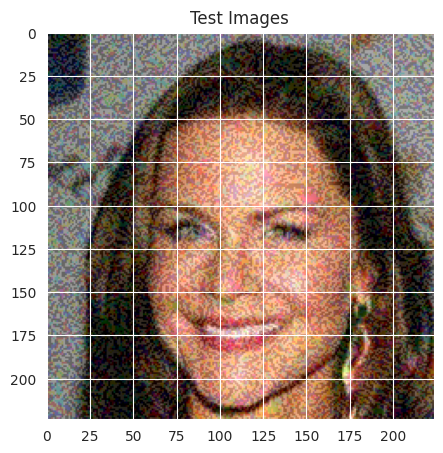

In [ ]:
'''
Generating different test cases to test the function Testing the function
'''

#Test Case 1:-Generating Adverserial Images

adv_analyzer=adverserial_analysis("FGSM",model_smile,model_gender,
                                  get_pred,get_pred,
                                  {'device':device,'logits':False},{'device':device,'logits':False},
                                  {'eps':0.1})
adv_images=adv_analyzer.generate_adverserial_images(images)

#print(adv_images.shape )
imshow(adv_images[3],"Test Images")



In [ ]:
# To do:-  Test Case if not integrate it for a single image Check if this works for a single image also

In [ ]:
#Test Case 2 :- Generating Adverserial images with different noise magnitudes
noise_settings={'0':{'eps':0},
                '0.000001':{'eps':0.000001},
                '0.00001':{'eps':0.00001},
                '0.0001':{'eps':0.0001},
                '0.0005':{'eps':0.0005},
                '0.0007':{'eps':0.0007},
                '0.001':{'eps':0.001},
                '0.003':{'eps':0.003},
                '0.005':{'eps':0.05},
                '0.01':{'eps':0.05},
                '0.05':{'eps':0.005},
                '0.25':{'eps':0.25}
                }

print(images[5].dim())
(adv_imgs,class_preds)=adv_analyzer.loop_over_noise(images[3],noise_settings)
for key, value in class_preds.items():
  print (key, value)


3
Atk _kwargs {'eps': 0}
FGSM
{'eps': 0}
Torch attack USed FGSM(model_name=ResNet, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=0)
(tensor([1]), tensor([[3.1099e-07, 1.0000e+00]]), tensor([0]), tensor([[1.0000e+00, 3.2497e-07]]))
Atk _kwargs {'eps': 1e-06}
FGSM
{'eps': 1e-06}
Torch attack USed FGSM(model_name=ResNet, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=1e-06)
(tensor([1]), tensor([[3.1337e-07, 1.0000e+00]]), tensor([0]), tensor([[1.0000e+00, 3.4036e-07]]))
Atk _kwargs {'eps': 1e-05}
FGSM
{'eps': 1e-05}
Torch attack USed FGSM(model_name=ResNet, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=1e-05)
(tensor([1]), tensor([[3.3485e-07, 1.0000e+00]]), tensor([0]), tensor([[1.0000e+00, 5.1102e-07]]))
Atk _kwargs {'eps': 0.0001}
FGSM
{'eps': 0.0001}
Torch attack USed FGSM(model_name=ResNet, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=0.0001)
(tensor([1

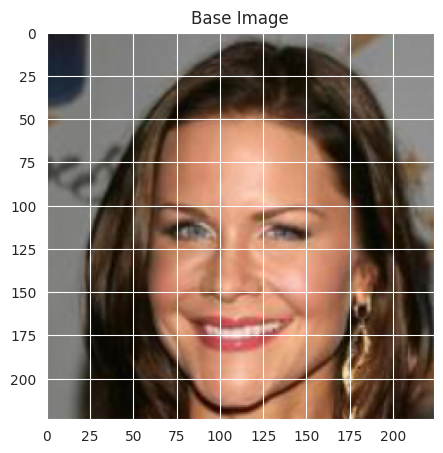

In [ ]:
imshow(adv_imgs[3],"Base Image")

In [ ]:
# To do plot for noise values .
import pandas as pd
class plot_images():
  '''
  Function to plot and compare the output of different classifiers
  '''
  def __init__(self,adv_analyzer,fig_size,show_image=True,
               compare_noise=False,start_from_zero=True):

    self.adv_analyzer=adv_analyzer
  def create_dataframe(self,class_preds):
    df =pd.DataFrame(columns=['Noise_magnitude','Classifier_Probability_Min','Classifier_Probability',
                                 'Concept_Probablity_Min','Concept_Probablity']
                     )
    #class_preds = {'key1': [0.5, 0.1, 0.8, 0.2, 0.9], 'key2': [0.8, 0.2, 0.7, 0.3, 0.6]}


    for key,values in class_preds.items():
        df.loc[key] = values




    pass
  def create_dataframe(fig_size,):
    pass
  def imshow(self,img):
    pass
  def plot_images_with_different_noise(self):
    pass
  def plot_img(self):
    pass
  def generate_noise_plots(self,type):
    pass


In [ ]:
def create_dataframe(noise_present=False):
  #Creates the required pandas dataframe
  if not noise_present:
    df =pd.DataFrame(columns=['Noise_magnitude','Classifier_Probability_Min','Classifier_Probability',
                                 'Concept_Probablity_Min','Concept_Probablity']
                     )

    classifier_ind=0
    concept_ind=0

    classifier_prob_arg_min=torch.argmin(class_preds['0'][1]).item()
    concept_prob_arg_min=torch.argmin(class_preds['0'][3]).item()

    data = [{'Noise_magnitude': key, 'Classifier_Probability_Min': value[1][0][classifier_prob_arg_min].item(),
          '  Classifier_Probability': value[1][0][classifier_ind].item(),'Concept_Probablity_Min':value[3][0][concept_prob_arg_min].item(),'Concept_Probablity':value[3][0][concept_ind].item()}
        for key, value in class_preds.items()]
    df['Noise_magnitude']=df['Noise_magnitude'].astype(float)

    df = pd.DataFrame(data)
    return df
  else :
    pass
df=create_dataframe()
print(df)

   Noise_magnitude  Classifier_Probability_Min    Classifier_Probability  \
0                0                3.109886e-07              3.109886e-07   
1         0.000001                3.133722e-07              3.133722e-07   
2          0.00001                3.348531e-07              3.348531e-07   
3           0.0001                6.131375e-07              6.131375e-07   
4           0.0005                2.205455e-06              2.205455e-06   
5           0.0007                2.485180e-06              2.485180e-06   
6            0.001                2.485825e-06              2.485825e-06   
7            0.003                7.071134e-07              7.071134e-07   
8            0.005                9.578218e-01              9.578218e-01   
9             0.01                9.578218e-01              9.578218e-01   
10            0.05                1.045255e-06              1.045255e-06   
11            0.25                9.603504e-01              9.603504e-01   

    Concept

In [ ]:
from scipy.stats import spearmanr
def spearman_correlation(df,threshold=0.005):
  # Filter the dataframe to only include rows where noise magnitude <= threshold
  df_filtered = df[df['Noise_magnitude'].astype(float) <= threshold]

  # Calculate the Spearman correlation between Concept_Probablity and Noise_magnitude
  corr, pvalue = spearmanr(df_filtered['Concept_Probablity_Min'], df_filtered['Noise_magnitude'])
  return corr
corr=spearman_correlation(df)
print(corr)

0.9500000000000001


ValueError: ignored

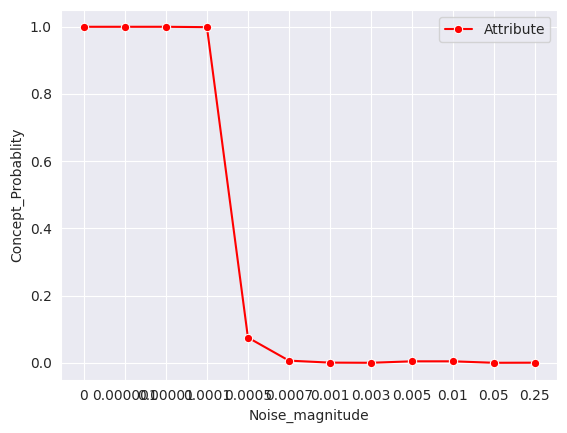

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
sns.lineplot(data=df, x='Noise_magnitude', y='Concept_Probablity', label='Attribute', marker="o",color='red')
sns.lineplot(data=df, x='Noise_magnitude', y= 'Classifier_Probability', label='Classifier',marker="^",color='grey')

#plt.title('Probability vs Noise Magnitude')

In [ ]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.9 MB/s eta 0:00:00


FGSM
Attack _name FGSM
Kwargs {'eps': 0.25}
Torch attack USed FGSM(model_name=ResNet, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=0.25)
torch.Size([3, 224, 224])
PSNR tensor(12.7243)
tensor(0.2311)
random
Attack _name random
Kwargs {'std': tensor(0.2311)}
there
Torch attack USed GN(model_name=ResNet, device=cpu, attack_mode=default, targeted=False, normalization_used=False, std=0.23109187185764313)


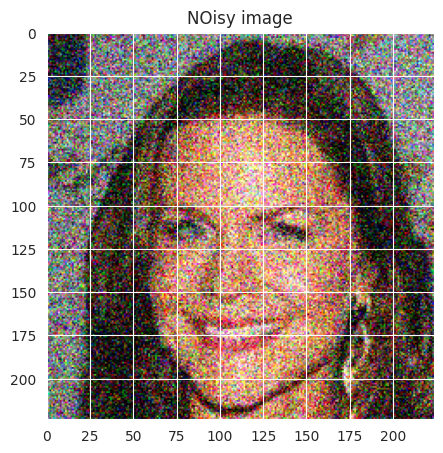

In [ ]:
from torchmetrics import PeakSignalNoiseRatio
#adv_analyzer_noise=adverserial_analysis("FGSM",model_smile,model_gender,
                                  #get_pred,get_pred,
                                  #{'device':device,'logits':False},{'device':device,'logits':False},
                                  #{'eps':0.01})
adv_images=adv_analyzer.generate_adverserial_images(images,atk_name="FGSM",
                                                    atk_kwargs={'eps':0.25})
#noise_imgs=adv_analyzer.generate_adverserial_images(images[3],classifier_fn=None,
#                                    pred_fn=None,pred_kwargs=None,
                                   # atk_name="random",atk_kwargs={'std':0.1})
def generate_psnr_images(img,adv_img):
  '''
  Function for generating noisy image given an original image
  '''
  #diff_img = img- adv_img

  # Calculate the mean and norm of the pixel values
  #mean_clean = torch.mean(img)
  #norm_diff = torch.norm(diff_img)

  # Calculate the SNR
  #snr = 20 * torch.log10(mean_clean / norm_diff)
  #snr=SignalNoiseRatio(img,adv_imgs)
  # Calcuate the signal to noise ratio between the images
  psnr_fn = PeakSignalNoiseRatio()
  psnr=psnr_fn(adv_img,img)
  print("PSNR",psnr)

  signal_power=1.0**2
  std=np.sqrt((signal_power/(10**(psnr/10)))/ (1 - 0) **2)
  print(std)
  noise_imgs=adv_analyzer.generate_adverserial_images(img,classifier_fn=None,
                                    pred_fn=None,pred_kwargs=None,
                                    atk_name="random",atk_kwargs={'std':std})

  return noise_imgs
print (adv_imgs[3].shape)

noise_images=(generate_psnr_images(images[3],adv_images[3]))
imshow(noise_images,"NOisy image")

class NoisyImageDataset(Dataset):
    def __init__(self, images, adv_images):
        self.images = images
        self.adv_images = adv_images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        adv_img = self.adv_images[idx]

        # Generate the noisy image
        noise_img = generate_psnr_images(img, adv_img)

        return noise_img
# Example usage
batch_size = 32
dataset = NoisyImageDataset(images, adv_images)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch in dataloader:
    # Use the noisy images in the batch for further processing
    print(batch.shape)

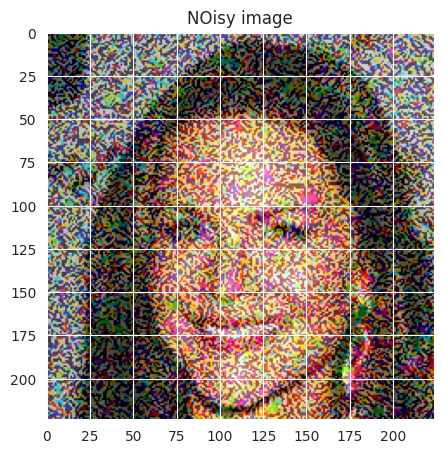

In [ ]:
imshow(adv_images[3],"NOisy image")

In [ ]:
def generate_ssim_images(img,adv_img):
  '''
  Function to generate noisy image using structural similarity index
  '''
  std_values=[0.0000001,]
  pass

'''
Test Cases:-
1. Check if the SSIM score works
2. Print the SSIM images for different noise magnitudes
3. See what is good level for the threshold
4. Print the result

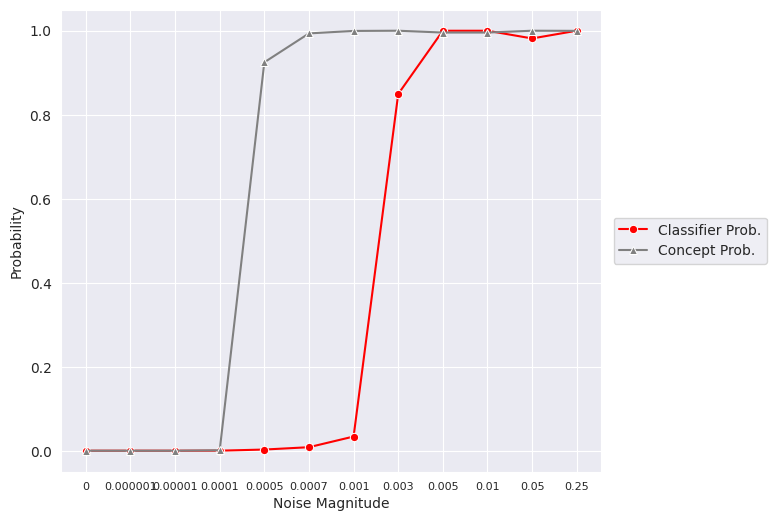

In [ ]:
def plot_lines(df,style='same',compare_random_noise=False):

    fig, ax = plt.subplots(figsize=(8, 6))
    if not compare_random_noise:
      if style == "index":
        sns.lineplot(data=df, x='Noise_magnitude', y='Classifier_Probability', label='Classifier Prob.',marker="o",color='red')
        sns.lineplot(data=df, x='Noise_magnitude', y='Concept_Probablity', label='Concept Prob.',marker="^",color='Grey')
      elif style == "minimum":
        sns.lineplot(data=df, x='Noise_magnitude', y='Classifier_Probability_Min', label='Classifier Prob.',marker="o",color='red')
        sns.lineplot(data=df, x='Noise_magnitude', y='Concept_Probablity_Min', label='Concept Prob.',marker="^",color='Grey')
      plt.xlabel('Noise Magnitude')
      plt.ylabel('Probability')
      ax.tick_params(axis='x', which='major', labelsize=8)
    else :
      pass

    plt.legend(loc='lower right')
    plt.subplots_adjust(right=0.8)
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
    return fig
fig=plot_lines(df,"minimum")

In [ ]:
gender_values,smile_values,list_images,eps_ext,preds=calc_values(images,img_id,eps_value,atk_name='Square')
print(gender_values,smile_values)
print(eps_ext)
plt.plot(gender_values,label='gender_val',marker='o')
plt.plot(smile_values,label='Smile_val',marker='o')
#plt.xscale('log')
plt.legend(["Gender 0 female 1 male","Smile 0 non smiling 1 similing"])

In [ ]:
noise_gender_values,noise_smile_values,noise_list_images,noise_eps_ext,preds_image=calc_values(images,img_id,eps_value,atk_name='GN')
print(noise_gender_values,noise_smile_values)
#print(eps_ext)
plt.plot(gender_values,label='gender_val',marker='o')
plt.plot(smile_values,label='Smile_val',marker='o')
plt.plot(noise_gender_values,label='gender_val',marker='o')
plt.plot(noise_smile_values,label='Smile_val',marker='o')
#plt.xscale('log')
plt.legend(["Gender ","Smile ", "Gender Noise","Smile Noise"])

In [ ]:
#print(preds[0.001]["gender_logits"],preds[0.001]["gender_pred"],preds[0.001]["smile_logits"].tolist()[0])
image_tensor=torch.stack(noise_list_images)
print(image_tensor.squeeze().shape)
imshow(preds_image["eps"][0.075]["adv_imgs"],"Original Image")
#imshow(image_tensor,"Image with noises")

In [ ]:
gender_values,smile_values,list_images,eps_ext,preds=calc_values(images,img_id,eps_value,atk_name='FGSM')
print(gender_values,smile_values)
print(eps_ext)
plt.plot(gender_values,label='gender_val',marker='o')
plt.plot(smile_values,label='Smile_val',marker='o')
#plt.xscale('log')
plt.legend(["Gender 0 female 1 male","Smile 0 non smiling 1 similing"])

In [ ]:
noise_gender_values,noise_smile_values,noise_list_images,noise_eps_ext,preds_image=calc_values(images,img_id,eps_value,atk_name='GN')
print(noise_gender_values,noise_smile_values)
print(eps_ext)
plt.plot(gender_values,label='gender_val',marker='o')
plt.plot(smile_values,label='Smile_val',marker='o')
plt.plot(noise_gender_values,label='gender_val',marker='o')
plt.plot(noise_smile_values,label='Smile_val',marker='o')
#plt.xscale('log')
plt.legend(["Gender ","Smile ", "Gender Noise","Smile Noise"])

In [ ]:
# Calculate the labels that flipped.
import tqdm

class_pred={}
for eps in eps_value:
  atk = torchattacks.FGSM(model_gender, eps=eps)
  smile_flipped_count=0
  gender_flipped_count=0
  smile_count=0
  gender_count=0
  length=0
  class_pred.update({eps:{
                    "gender_labels":[],
                    "smile_labels":[],
                    "gender_predict":[],
                    "smile_predict":[],
                    "adv_gender_pred":[],
                    "adv_smile_pred":[],
                    "flipped_smile": None,
                    "flipped_gender": None,
                    "gender_accuracy": None,
                    "smile_accuracy": None }})

  for images,labels in test_dl:
      gender_labels=labels[:,gender_attr_idx]
      smile_labels=labels[:,smile_attr_idx]
      gender_pred,gender_logits,=get_pred(model_gender,images,device)
      smile_pred,smile_logits,=get_pred(model_smile,images,device)
      #print(type(smile_pred))
      adv_images = atk(images, gender_pred)
      adv_gender_pred,adv_gen_logits=get_pred(model_gender,adv_images,device)
      adv_smile_pred,adv_smile_logits=get_pred(model_smile,adv_images,device)
      smile_flipped_count+=torch.sum(smile_pred == adv_smile_pred)
      gender_flipped_count+=torch.sum(gender_pred==adv_gender_pred)
      smile_count+=torch.sum(smile_pred == smile_labels)
      gender_count+=torch.sum(gender_pred==gender_labels)
      #Make this cleaner
      class_pred[eps]["gender_labels"].extend(gender_labels.tolist())
      class_pred[eps]["smile_labels"].extend(smile_labels.tolist())
      class_pred[eps]["gender_predict"].extend(gender_pred.tolist())
      class_pred[eps]["smile_predict"].extend(smile_pred.tolist())
      class_pred[eps]["adv_gender_pred"].extend(adv_gender_pred.tolist())
      class_pred[eps]["adv_smile_pred"].extend(adv_smile_pred.tolist())



      #print("Total Smile not converted",torch.sum(smile_pred == adv_smile_pred))
      length+=batch_size
  class_pred[eps]["flipped_smile"]=(length-smile_flipped_count)/length
  class_pred[eps]["flipped_gender"]=(length-gender_flipped_count)/length
  class_pred[eps]["gender_accuracy"]=(gender_count)/length
  class_pred[eps]["smile_accuracy"]=(smile_count)/length
  print("For Eps ", eps, " the number of smiles that flipped were" ,class_pred[eps]["flipped_smile"])
  print("For eps", eps," the gender detected that were flipped are " ,class_pred[eps]["flipped_gender"])
  print("For eps", eps," the gender recogntion accuracy was  ", class_pred[eps]["gender_accuracy"])
  print("For eps", eps," the smile recogntion accuracy was  " ,class_pred[eps]["smile_accuracy"])



In [ ]:
import pickle
filename='/content/gdrive/MyDrive/FairFaceRecExptResults/equal_class_pred.pkl'





In [ ]:
with open(filename, 'wb') as handle:
    pickle.dump(class_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(filename, 'rb') as handle:
    b = pickle.load(handle)
print(type(b))

In [ ]:
print("Balanced_prediction")
print(b[0.001]["gender_predict"])
print(b[0.001]["adv_gender_pred"])
print(b[0.001]["adv_gender_pred"])

In [ ]:
def calcuate_distribution(class_pred,eps):
  cond_1=[0,1,1,0]
  cond_2=[0,0,1,1]
  cond_3=[1,1,0,0]
  cond_4=[1,0,0,1]
  cond_1_count=0
  cond_2_count=0
  cond_3_count=0
  cond_4_count=0
  dec_arr=np.vstack((np.asarray(class_pred[eps]["gender_predict"]),
                       np.asarray(class_pred[eps]["smile_predict"]),
                       np.asarray(class_pred[eps]["adv_gender_pred"]),
                       np.asarray(class_pred[eps]["adv_smile_pred"])),
                       ).T

  #cond_1_instances=np.where(cond_1==dec_arr,axis=-1)
  #cond_2_instances=np.where(cond_2==dec_arr,axis=-1)
  #cond_3_instances=np.where(cond_3==dec_arr,axis=-1)
  #cond_4_instances=np.where(cond_4==dec_arr,axis=-1)
  unq, cnt = np.unique(dec_arr, axis=0, return_counts=True)
  print("Uniuqe values",unq)
  print("Count",cnt)
  a=np.where(cond_1,0,1)
  #print(a)
  for i , row in enumerate (unq):
    print(row)
    if (np.array_equal(cond_1,row)):
      cond_1_count=cnt[i]
    elif (np.array_equal(cond_2,row)):
      cond_2_count=cnt[i]
    elif(np.array_equal(cond_3,row)):
      cond_3_count=cnt[i]
    elif (np.array_equal(cond_4_count,row)):
      cond_4_count=cnt[i]
  print(cond_1_count,cond_2_count,cond_3_count,cond_4_count)

  #print(cond_1_instances,cond_2_instances,cond_3_instances,cond_4_instances)
  print(dec_arr.shape)
  #print(dec_arr[k])
  #print(class_pred[eps]["gender_predict"][k],class_pred[eps]["smile_predict"][k],
        #class_pred[eps]["adv_gender_pred"][k],
                   #class_pred[eps]["adv_smile_pred"][k])
  return cond_1_count,cond_2_count,cond_3_count,cond_4_count
#calcuate_distribution(class_pred,eps)
for eps in eps_value:
  print ("For the eps value",eps)
  print (calcuate_distribution(class_pred,eps))

In [ ]:
key_names=['gender_labels','smile_labels','gender_pred','smile_pred','gender_softmax','smile_softmax']
for eps in eps_value:
  key_names.append("gender_"+str(eps))
  key_names.append("smile_"+str(eps))
#key_names.extend(eps_value)
print(key_names)
pred_values={}
for i in key_names:
  pred_values[i]=[]
print(pred_values)
for images,labels in test_dl:
      gender_labels=labels[:,gender_attr_idx]
      smile_labels=labels[:,smile_attr_idx]
      gender_pred,gender_logits,=get_pred(model_gender,images,device)
      smile_pred,smile_logits,=get_pred(model_smile,images,device)
      #print(type(smile_pred))
      #adv_images = atk(images, gender_pred)
      #adv_gender_pred,adv_gen_logits=get_pred(model_gender,adv_images,device)
      #adv_smile_pred,adv_smile_logits=get_pred(model_smile,adv_images,device)

      pred_values["gender_labels"].extend(gender_labels.tolist())
      pred_values["smile_labels"].extend(smile_labels.tolist())
      pred_values["gender_softmax"].extend(gender_logits.tolist())
      pred_values["smile_softmax"].extend(smile_logits.tolist())
      pred_values["gender_pred"].extend(gender_pred.tolist())
      pred_values["smile_pred"].extend(smile_pred.tolist())

      for eps in eps_value:
        atk = torchattacks.FGSM(model_gender, eps=eps)
        adv_images = atk(images, gender_pred)
        adv_gender_pred,adv_gen_logits=get_pred(model_gender,adv_images,device)
        adv_smile_pred,adv_smile_logits=get_pred(model_smile,adv_images,device)
        pred_values["gender_"+str(eps)].extend(adv_gen_logits.tolist())
        pred_values["smile_"+str(eps)].extend(adv_smile_logits.tolist())



In [ ]:
f = open('mybalancedcsvfile.csv','wb')
w = csv.DictWriter(f,my_dict.keys())
w.writerows(my_dict)
f.close()

In [ ]:
print(len(pred_values["smile_1e-06"]))
print(len(pred_values["gender_1e-06"]))


In [ ]:
import pickle
filename_lee='/content/gdrive/MyDrive/FairFaceRecExptResults/class_pred_lee2.pkl'

In [ ]:
with open(filename_lee, 'wb') as handle:
    pickle.dump(pred_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Printing done")

In [ ]:
with open(filename_lee, 'rb') as handle:
    pred_values = pickle.load(handle)
print(type(pred_values))
print(pred_values.keys())

In [ ]:
import csv
csv_filename='/content/gdrive/MyDrive/FairFaceRecExptResults/class_outputs_large.csv'
test_data=[]
for i in range (len(pred_values[key_names[0]])):
      row={}

      for key in pred_values.keys():
        row.update({key:pred_values[key][i]})
      test_data.append(row)
        #print(row)
print("Row Appended")

with open(csv_filename, 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, pred_values.keys())
    w.writeheader()
    w.writerows(test_data)
print("Writing Done")


In [ ]:
with open(filename_lee, 'rb') as f:
    x = pickle.load(f)

In [ ]:
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismtach found at', key_item_1[0])
            else:
                raise Exception
    if models_differ == 0:
        print('Models match perfectly! :)')
compare_models(model_gender,model_smile)

In [ ]:
def comp_model(model1,model2):
  for p1, p2 in zip(model1.parameters(), model2.parameters()):
      if p1.data.ne(p2.data).sum() > 0:
          return False
  return True


In [ ]:
def validate_state_dicts(model_state_dict_1, model_state_dict_2):
    if len(model_state_dict_1) != len(model_state_dict_2):
        logger.info(
            f"Length mismatch: {len(model_state_dict_1)}, {len(model_state_dict_2)}"
        )
        return False

    # Replicate modules have "module" attached to their keys, so strip these off when comparing to local model.
    if next(iter(model_state_dict_1.keys())).startswith("module"):
        model_state_dict_1 = {
            k[len("module") + 1 :]: v for k, v in model_state_dict_1.items()
        }

    if next(iter(model_state_dict_2.keys())).startswith("module"):
        model_state_dict_2 = {
            k[len("module") + 1 :]: v for k, v in model_state_dict_2.items()
        }

    for ((k_1, v_1), (k_2, v_2)) in zip(
        model_state_dict_1.items(), model_state_dict_2.items()
    ):
        if k_1 != k_2:
            logger.info(f"Key mismatch: {k_1} vs {k_2}")
            return False
        # convert both to the same CUDA device
        if str(v_1.device) != "cuda:0":
            v_1 = v_1.to("cuda:0" if torch.cuda.is_available() else "cpu")
        if str(v_2.device) != "cuda:0":
            v_2 = v_2.to("cuda:0" if torch.cuda.is_available() else "cpu")

        if not torch.allclose(v_1, v_2):
            logger.info(f"Tensor mismatch: {v_1} vs {v_2}")
            return False

In [ ]:
print(validate_state_dicts(model_gender.state_dict(),model_smile.state_dict()))